# Partial Least Squares
This script will analyse the ERA5 and PFT dataset together and explore their relationship.

### Imports

In [9]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, cross_val_score

### Load Datasets

In [2]:
ds_era5 = xr.open_dataset("data/era5_climate_data/era5-land-yearly-means-sliced.nc")
ds_pft = xr.open_dataset("data/regridded_pft_data/pft-yearly-sliced.nc")

In [3]:
# Choose climate features
CLIM_FEATURES = [
    't2m', 'vpd', 'tp', 
    't2m_season_JJA', 't2m_season_DJF', 'tp_season_DJF', 'tp_season_JJA', 'vpd_season_JJA', 'vpd_season_DJF'
]

# Define PFT variable names
PFT_VARS = [
    'BARE','BUILT','GRASS-MAN','GRASS-NAT',
    'SHRUBS-BD','SHRUBS-BE','SHRUBS-NE','SHRUBS-ND',
    'TREES-BD','TREES-BE','TREES-NE','TREES-ND',
    'WATER_OCEAN','WATER_INLAND','SNOWICE'
]

### Transform data
Apply CLR to PFT data because it is compositional.

In [4]:
def pft_dataset_to_clr_da(pft_ds, pft_vars=PFT_VARS, pft_dim='pft', eps=1e-6):
    """
    Take a Dataset with per-PFT variables and return a CLR-transformed DataArray
    with dims: (pft, year, latitude, longitude).
    """
    # Stack variables -> 'pft' axis
    pft_da = pft_ds[pft_vars].to_array(pft_dim) 

    # CLR transform per-sample
    P = xr.where(pft_da <= 0, eps, pft_da)
    logP = np.log(P)
    gmean = logP.mean(pft_dim)
    clr = logP - gmean
    clr.name = 'PFT_CLR'
    clr.attrs['long_name'] = 'Centered log-ratio of PFT fractions'
    clr.attrs['units'] = '' 

    return clr

# Align climate & PFT on years/space and stack samples
def build_pooled_matrices(combined, pft_ds, feature_names):
    """
    Returns:
      X: (n_samples, n_features)
      Y: (n_samples, n_pfts)  [CLR-transformed]
      meta: dict(year, lat, lon, feature_names, pft_names)
    """

    # X block (features)
    Xds = combined[feature_names] 

    # Y block (CLR of PFTs) -> DataArray with 'pft' axis
    Yda = pft_dataset_to_clr_da(pft_ds) 

    # Align on common years/space
    Xds, Yda = xr.align(Xds, Yda, join='inner')

    # Stack samples (year, lat, lon) -> 'sample'
    Xstack = (Xds
              .to_array('feature')                         
              .transpose('feature','year','latitude','longitude')
              .stack(sample=('year','latitude','longitude')))
    Ystack = (Yda
              .transpose('pft','year','latitude','longitude')
              .stack(sample=('year','latitude','longitude')))

    # Keep only samples with all features & all PFTs present
    valid = (~np.isnan(Xstack)).all('feature') & (~np.isnan(Ystack)).all('pft')
    Xstack = Xstack.sel(sample=valid)
    Ystack = Ystack.sel(sample=valid)

    # Transform to numpy arrays
    X = Xstack.transpose('sample','feature').values
    Y = Ystack.transpose('sample','pft').values

    # Meta for grouping/reshaping
    year = Xstack['sample'].indexes['sample'].get_level_values('year').values
    lat  = Xstack['sample'].indexes['sample'].get_level_values('latitude').values
    lon  = Xstack['sample'].indexes['sample'].get_level_values('longitude').values
    meta = dict(
        year=year, lat=lat, lon=lon,
        feature_names=list(Xstack['feature'].values),
        pft_names=list(Ystack['pft'].values)
    )
    return X, Y, meta

X, Y, meta = build_pooled_matrices(ds_era5, ds_pft, CLIM_FEATURES)

### Partial Least Squares

In [5]:
# Scale X and Y to zero mean, unit variance
Xscaler = StandardScaler(with_mean=True, with_std=True)
Yscaler = StandardScaler(with_mean=True, with_std=True) 

Xz = Xscaler.fit_transform(X)
Yz = Yscaler.fit_transform(Y)

# Choose number of PLS components
n_comp = 2
pls = PLSRegression(n_components=n_comp)

# Blocked CV by year
years = meta['year']
cv = GroupKFold(n_splits=5)
scores = cross_val_score(pls, Xz, Yz, groups=years, cv=cv, scoring='r2') 

print(f"Year-blocked CV R^2 (mean ± sd): {scores.mean():.3f} ± {scores.std():.3f}")

# Fit final model on all samples
pls.fit(Xz, Yz)

# Inspect/loadings/weights (what climate combos and PFT axes each component represents)
x_load = pls.x_loadings_      # shape (n_features, n_comp)
y_load = pls.y_loadings_      # shape (n_pfts,    n_comp)
x_w    = pls.x_weights_       # shape (n_features, n_comp)
y_w    = pls.y_weights_       # shape (n_pfts,    n_comp)
coef   = pls.coef_            # shape (n_features, n_pfts) mapping Xz → Yz

nf = len(meta['feature_names'])
npft = len(meta['pft_names'])

if coef.shape == (nf, npft):
    coef_mat = coef
elif coef.shape == (npft, nf):
    coef_mat = coef.T
else:
    raise ValueError(
        f"Unexpected coef_.shape={coef.shape}; "
        f"expected {(nf, npft)} or {(npft, nf)}."
    )

coef_da = xr.DataArray(
    coef_mat,
    dims=('feature', 'pft'),
    coords={'feature': meta['feature_names'], 'pft': meta['pft_names']},
    name='PLS_coefficients (standardized space)'
)

Year-blocked CV R^2 (mean ± sd): 0.230 ± 0.005


### Plots

##### Plot PLS Coefficients

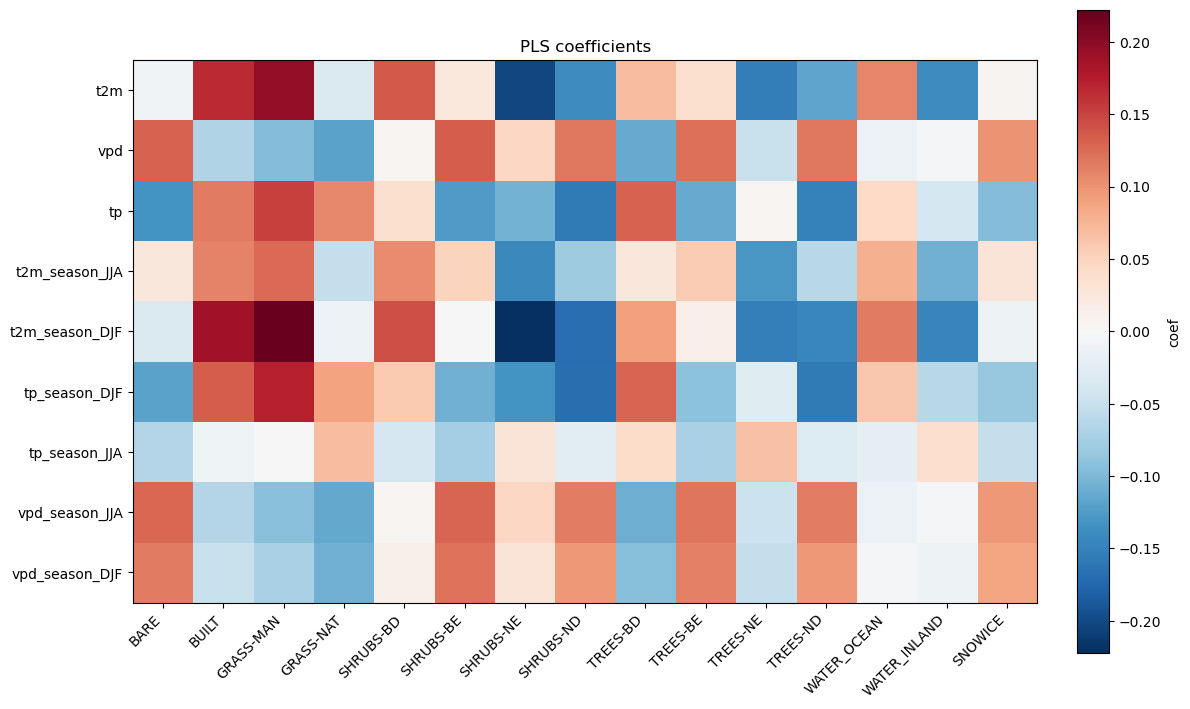

In [7]:
nf = len(meta['feature_names'])
npft = len(meta['pft_names'])
coef_ = pls.coef_
coef_mat = coef_ if coef_.shape == (nf, npft) else coef_.T

fig, ax = plt.subplots(figsize=(0.6*npft+3, 0.6*nf+2))
im = ax.imshow(coef_mat, cmap='RdBu_r', vmin=-np.nanmax(abs(coef_mat)), vmax=np.nanmax(abs(coef_mat)))
ax.set_yticks(range(nf));   ax.set_yticklabels(meta['feature_names'])
ax.set_xticks(range(npft)); ax.set_xticklabels(meta['pft_names'], rotation=45, ha='right')
ax.set_title("PLS coefficients")
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='coef')
plt.tight_layout()

plt.savefig("figures/pls_coefficients.png", dpi=300, bbox_inches='tight')

##### Plot Weights of the First Component

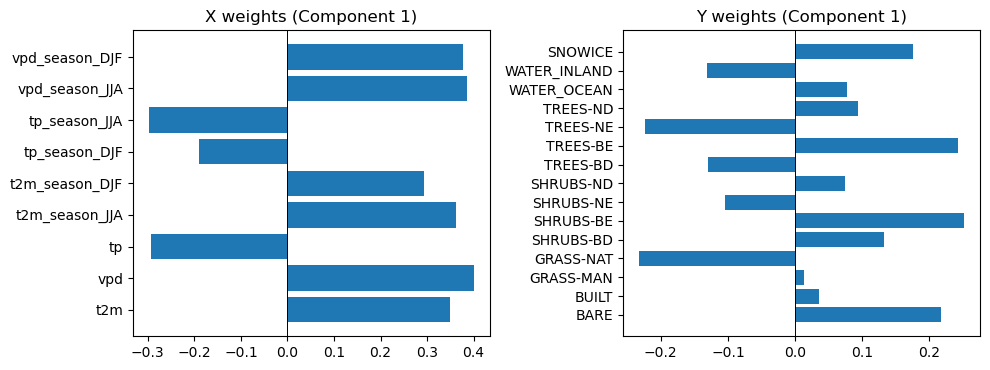

In [8]:
# First Component
comp = 0 
xw = pls.x_weights_[:, comp]
yw = pls.y_weights_[:, comp]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.8), sharey=False)
axes[0].barh(meta['feature_names'], xw)
axes[0].set_title(f'X weights (Component {comp+1})'); axes[0].axvline(0,color='k',lw=0.7)
axes[1].barh(meta['pft_names'], yw)
axes[1].set_title(f'Y weights (Component {comp+1})'); axes[1].axvline(0,color='k',lw=0.7)
plt.tight_layout()
plt.savefig(f"figures/pls_weights_comp{comp+1}.png", dpi=300, bbox_inches='tight')

##### Plot Scores of Component 1 on Map

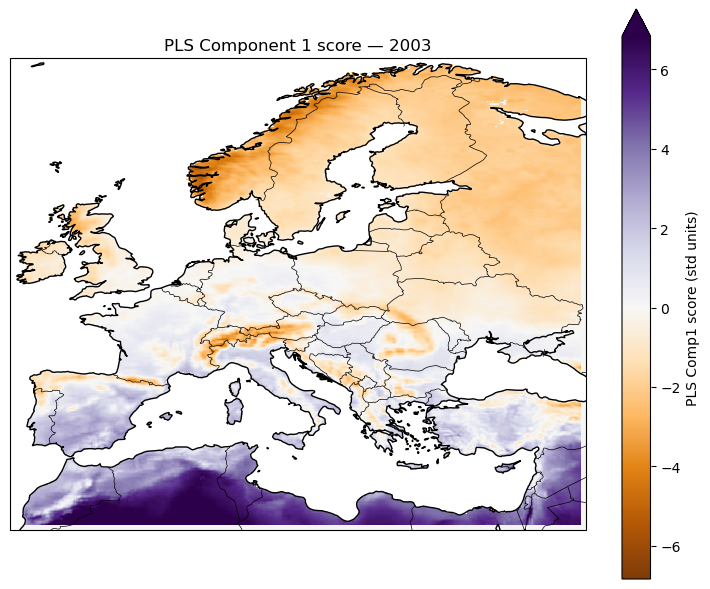

In [ ]:
T = pls.transform(Xz)

def scores_to_grid(T, comp_idx, meta):
    """
    Return DataArray of scores for one component with dims (year, latitude, longitude).
    """
    da = xr.DataArray(
        T[:, comp_idx],
        dims=('sample',),
        coords={
            'sample': np.arange(T.shape[0]),
            'year':     ('sample', meta['year']),
            'latitude': ('sample', meta['lat']),
            'longitude':('sample', meta['lon']),
        },
        name=f'PLS_comp{comp_idx+1}_score'
    ).set_index(sample=('year','latitude','longitude')).unstack('sample')
    return da

score1 = scores_to_grid(T, 0, meta)

# Map Component 1 for year 2003
yr = int(np.unique(meta['year'])[10])
da_map = score1.sel(year=yr)

fig = plt.figure(figsize=(7.5, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
extent = [float(da_map['longitude'].min())-0.5, float(da_map['longitude'].max())+0.5,
          float(da_map['latitude'].min())-0.5, float(da_map['latitude'].max())+0.5]
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='whitesmoke', zorder=0)
ax.coastlines('50m'); ax.add_feature(cfeature.BORDERS, linewidth=0.5)
im = da_map.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PuOr', robust=True,
                 cbar_kwargs={'label': 'PLS Comp1 score (std units)'})
ax.set_title(f'PLS Component 1 score - {yr}')
plt.tight_layout()

plt.savefig("figures/pls_comp1_map.png", dpi=300, bbox_inches='tight')


##### Plot R² and RMSE bars

In [ ]:
Y_pred = pls.predict(Xz)

# Calculate R² and RMSE per PFT
n_pfts = Y.shape[1]
r2_pft = np.zeros(n_pfts)
rmse_pft = np.zeros(n_pfts)

for j in range(n_pfts):
    # Actual and predicted values for this PFT
    y_true = Yz[:, j]
    y_pred = Y_pred[:, j]
    
    # Calculate R²
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - y_true.mean())**2)
    r2_pft[j] = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0.0
    
    # Calculate RMSE
    rmse_pft[j] = np.sqrt(np.mean((y_true - y_pred)**2))


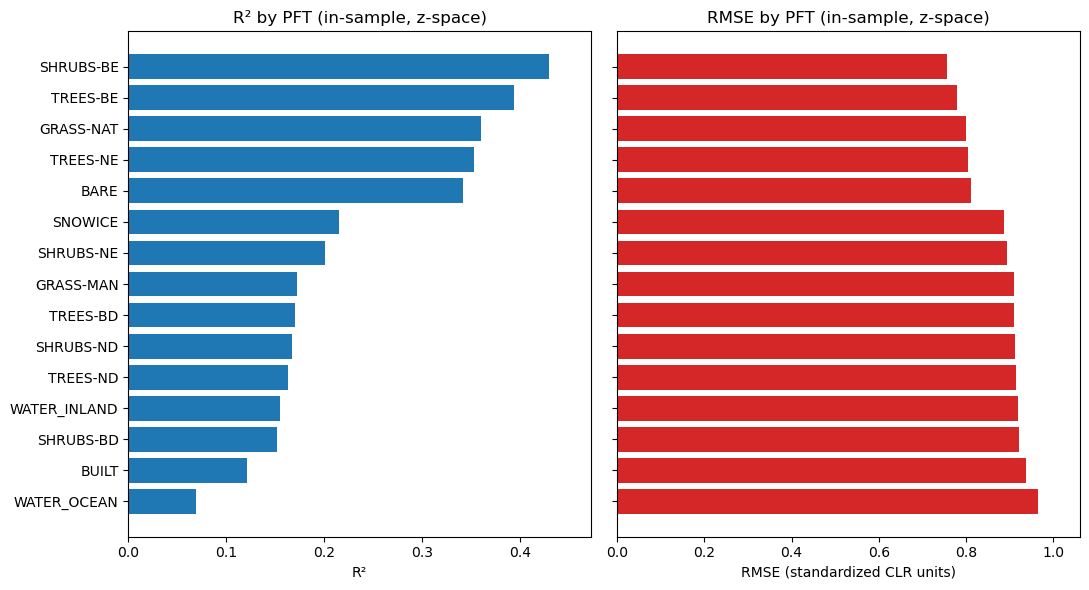

In [ ]:
def plot_r2_rmse_bars(pft_names, r2, rmse, title_suffix='(in-sample, z-space)'):
    # sort by R² (descending) for readability
    order = np.argsort(r2)[::-1]
    r2_s  = r2[order]
    rmse_s= rmse[order]
    names = [pft_names[i] for i in order]

    fig, axes = plt.subplots(1, 2, figsize=(11, 6), sharey=True)

    # R² bars
    axes[0].barh(names, r2_s, color='tab:blue')
    axes[0].set_xlabel('R²')
    axes[0].set_title(f'R² by PFT {title_suffix}')
    axes[0].invert_yaxis()
    axes[0].set_xlim(0, max(0.0, float(r2_s.max())*1.1))

    # RMSE bars (z-units)
    axes[1].barh(names, rmse_s, color='tab:red')
    axes[1].set_xlabel('RMSE (standardized CLR units)')
    axes[1].set_title(f'RMSE by PFT {title_suffix}')
    axes[1].set_xlim(0, max(1.0, float(rmse_s.max())*1.1))

    plt.tight_layout()
    return fig, axes


fig = plot_r2_rmse_bars(meta['pft_names'], r2_pft, rmse_pft)
fig.savefig("figures/pls_r2_rmse_bars.png", dpi=300, bbox_inches='tight')

##### Plot R² vs RMSE
We can clearly see the two groups, where one group is clearly better predictable by climate data

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'R² vs RMSE (z-space)'}, xlabel='R²', ylabel='RMSE (standardized)'>)

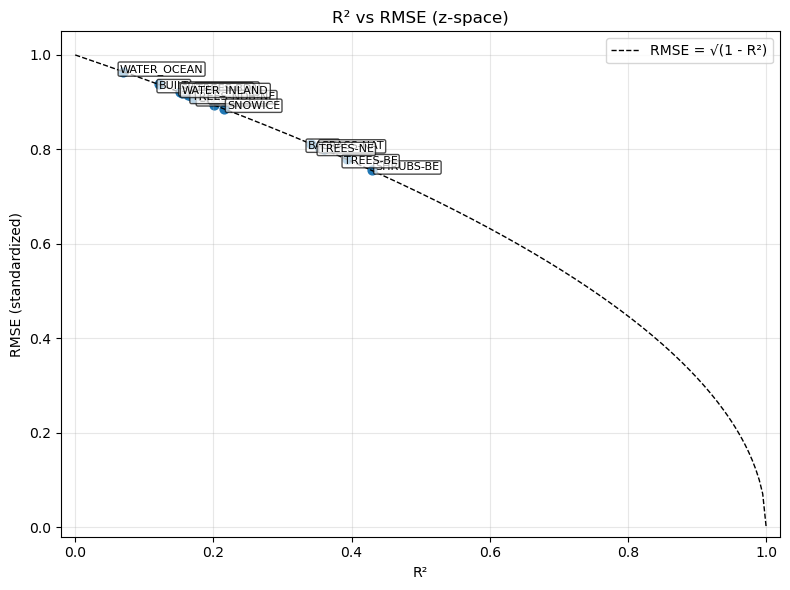

In [ ]:
def plot_r2_vs_rmse_labeled(pft_names, r2, rmse, title='R² vs RMSE (z-space)'):
    th_r2 = np.linspace(0, 1, 200)
    th_rmse = np.sqrt(1 - th_r2)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(th_r2, th_rmse, 'k--', lw=1.0, label='RMSE = √(1 - R²)')
    ax.scatter(r2, rmse, s=40)

    texts = []
    for name, x, y in zip(pft_names, r2, rmse):
        texts.append(ax.text(x, y, name, fontsize=8,
                             bbox=dict(boxstyle='round,pad=0.15', fc='white', alpha=0.7)))

    for i, t in enumerate(texts):
        t.set_position((t.get_position()[0] + 0.005*(i%3-1),
                        t.get_position()[1] + 0.01*((i//3)%3-1)))

    ax.set_xlabel('R²')
    ax.set_ylabel('RMSE (standardized)')
    ax.set_xlim(-0.02, 1.02); ax.set_ylim(-0.02, 1.05)
    ax.grid(alpha=0.3); ax.legend(loc='upper right')
    ax.set_title(title)
    plt.tight_layout()
    
    return fig


fig = plot_r2_vs_rmse_labeled(meta['pft_names'], r2_pft, rmse_pft)
fig.savefig("figures/pls_r2_vs_rmse.png", dpi=300, bbox_inches='tight')